In [1]:
import os
import re
import torch
import numpy as np 
import matplotlib.pyplot as plt
import cv2
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn
import torchvision.models as models

In [2]:
train_images="/home/saran/Desktop/Python Projects/Object Detection/PNGImages/"
train_maps="/home/saran/Desktop/Python Projects/Object Detection/Annotations/"

classes=['bicycle','car','motorbike','person']

class_dict = {classes[i]: i for i in range(len(classes))}

N_CLASSES=4
H,W=224,224
SPLIT_SIZE=7
BATCH_SIZE=32

In [3]:
class_dict

{'bicycle': 0, 'car': 1, 'motorbike': 2, 'person': 3}

# Data Extraction

In [4]:
# This function preprocesses a .txt file containing object detection annotations.
def preprocess_txt(filename, class_name):
    bounding_boxes = []
    height = 0
    width = 0
    xmin = 0
    ymin = 0
    xmax = 0
    ymax = 0

    with open(filename, 'r') as file:
        for line in file:
            if(line.find("Image size") != -1):
                width = float(line.split(":")[1].split("x")[0])
                height = float(line.split(":")[1].split("x")[1])
            elif (line.find("Bounding box for object") != -1):
                temp = line.split(':')[1]
                numbers = re.findall(r'\d+', temp)
                xmin, ymin, xmax, ymax = [int(num) for num in numbers]
                # Calculate normalized bounding box coordinates.
                bounding_box = [
                    (xmin + xmax) / (2 * width),
                    (ymin + ymax) / (2 * height),
                    (xmax - xmin) / width,
                    (ymax - ymin) / height,
                    class_dict[class_name]
                ]
                bounding_boxes.append(bounding_box)
                
    return torch.Tensor(bounding_boxes)

In [5]:
def generate_output(bounding_boxes):
    # Initialize output label tensor
    output_label = np.zeros((SPLIT_SIZE, SPLIT_SIZE, N_CLASSES + 5))

    # Iterate through bounding boxes
    for b in range(len(bounding_boxes)):
        # Calculate grid positions
        grid_x = bounding_boxes[..., b, 0] * SPLIT_SIZE
        grid_y = bounding_boxes[..., b, 1] * SPLIT_SIZE
        
        # Convert to integer grid indices
        i = int(grid_x)
        j = int(grid_y)

        # Assign values to output label tensor
        output_label[i, j, 0:5] = [1., grid_x % 1, grid_y % 1, bounding_boxes[..., b, 2], bounding_boxes[..., b, 3]]
        output_label[i, j, 5 + int(bounding_boxes[..., b, 4])] = 1.
        
    return torch.tensor(output_label)

In [6]:
boxes = []
for cn in os.listdir(train_maps):
    for file in os.listdir(train_maps + cn):
        file_path = train_maps + cn + "/" + file
        class_name = ""
        if(cn == "Caltech_motorbikes_side"):
            class_name = "motorbike"
        elif(cn == "ETHZ_motorbike-testset"):
            class_name = "motorbike"
        elif(cn == "TUGraz_bike"):
            class_name = "bicycle"
        elif(cn == "TUGraz_cars"):
            class_name = "car"
        elif(cn == "Caltech_cars"):
            class_name = "car"
        elif(cn == "ETHZ_sideviews-cars"):
            class_name = "car"
        elif(cn == "TUGraz_person"):
            class_name = "person"
        bounding_boxes = preprocess_txt(file_path, class_name)
        boxes.append(generate_output(bounding_boxes))

boxes = torch.stack(boxes)

In [7]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor(),
])

images = []
for cn in os.listdir(train_images):
    for file in os.listdir(train_images + cn):
        file_path = train_images + cn + "/" + file
        class_name = ""
        if(cn == "Caltech_motorbikes_side"):
            class_name = "motorbike"
        elif(cn == "ETHZ_motorbike-testset"):
            class_name = "motorbike"
        elif(cn == "TUGraz_bike"):
            class_name = "bicycle"
        elif(cn == "TUGraz_cars"):
            class_name = "car"
        elif(cn == "Caltech_cars"):
            class_name = "car"
        elif(cn == "ETHZ_sideviews-cars"):
            class_name = "car"
        elif(cn == "TUGraz_person"):
            class_name = "person"
        img = Image.open(file_path).convert('RGB')
        img_tensor = transform(img)
        images.append(img_tensor)

images = torch.stack(images)

# Model Building

In [8]:
NUM_FILTERS = 512
OUTPUT_DIM = int(N_CLASSES + 5)

# Load pre-trained ResNet50
base_model = models.resnet50(pretrained=True)

# Remove the last fully connected layer
base_model = nn.Sequential(*list(base_model.children())[:-2])

# Freeze the base model
for param in base_model.parameters():
    param.requires_grad = False


# Define additional layers
conv_layers = nn.Sequential(
    nn.Conv2d(2048, NUM_FILTERS, kernel_size=3, padding=1),
    nn.BatchNorm2d(NUM_FILTERS),
    nn.LeakyReLU(0.1),
    
    nn.Conv2d(NUM_FILTERS, NUM_FILTERS, kernel_size=3, padding=1),
    nn.BatchNorm2d(NUM_FILTERS),
    nn.LeakyReLU(0.1),
    
    nn.Conv2d(NUM_FILTERS, NUM_FILTERS, kernel_size=3, padding=1),
    nn.BatchNorm2d(NUM_FILTERS),
    nn.LeakyReLU(0.1)
)

flatten = nn.Flatten()

dense_layers = nn.Sequential(
    nn.Linear(NUM_FILTERS * (H // 32) * (W // 32), NUM_FILTERS),
    nn.BatchNorm1d(NUM_FILTERS),
    nn.LeakyReLU(0.1),
    
    nn.Linear(NUM_FILTERS, int(SPLIT_SIZE * SPLIT_SIZE * OUTPUT_DIM)),
    nn.Sigmoid()
)

# Combine all layers into a single sequential model
model = nn.Sequential(
    base_model,
    conv_layers,
    flatten,
    dense_layers,
    nn.Unflatten(1, (SPLIT_SIZE, SPLIT_SIZE, OUTPUT_DIM))
)

# Print model summary
# print(model)

/home/saran/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/saran/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
def difference_of_squares(x, y):
    return torch.sum((y - x)**2)

def yolo_loss(y_true, y_pred):
    target = y_true[..., 0]
    
    #--------------------------------------- for object
    
    target_indices = target == 1
    conf_pred = y_pred[target_indices]
    conf_target = y_true[target_indices]
    
    object_loss = difference_of_squares(conf_pred[..., 0].float(), torch.ones_like(conf_target[..., 0]).float())
    
    #------------------------------------------------------ for no object
    
    target_indices_no_obj = target == 0
    conf_pred = y_pred[target_indices_no_obj]
    conf_target = y_true[target_indices_no_obj]

    # no_obj_loss = difference_of_squares(conf_pred[..., 0].float(), torch.zeros_like(conf_pred[..., 0]).float())
    no_obj_loss = difference_of_squares(conf_pred[..., 0].float(), conf_target[..., 0].float())
    
    #-------------------------------------------------------- for object class loss
    
    classes_pred = y_pred[target_indices][:, 5:]
    classes_target = y_true[target_indices][:, 5:]
    
    class_loss = difference_of_squares(classes_pred.float(), classes_target.float())
    
    #--------------------------------------------------------- for object center loss
    
    center_pred = y_pred[target_indices][:, 1:3]
    center_target = y_true[target_indices][:, 1:3]
    
    center_loss = difference_of_squares(center_pred.float(), center_target.float())
    
    #------------------------------------------------------- for width and height
    
    size_pred = y_pred[target_indices][:, 3:5]
    size_target = y_true[target_indices][:, 3:5]
    
    area_loss = difference_of_squares(torch.sqrt(torch.abs(size_pred.float())), torch.sqrt(torch.abs(size_target.float())))
    
    box_loss = center_loss + area_loss
    
    lambda_coord = 5
    lambda_no_obj = 0.5
    
    loss = object_loss + (lambda_no_obj * no_obj_loss) + lambda_coord * box_loss + class_loss
    
    return loss

# Training

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
images = images.to(device)
boxes = boxes.to(device)

# Define your loss function and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Assuming batch size of 32 and iterating through batches
    batch_size = 32
    for i in range(0, len(images), batch_size):
        img_batch = images[i:i+batch_size]
        target_batch = boxes[i:i+batch_size]

        # Forward pass
        outputs = model(img_batch)

        # Assuming you have a custom YOLO-like loss function
        loss = yolo_loss(target_batch,outputs)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print average loss for epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {(running_loss * batch_size) / len(images)}')

Epoch [1/50], Loss: 85.33064576246737
Epoch [2/50], Loss: 79.91382582448455
Epoch [3/50], Loss: 68.53836903337977
Epoch [4/50], Loss: 64.07496441981588
Epoch [5/50], Loss: 58.55525724031512
Epoch [6/50], Loss: 53.99998880233567
Epoch [7/50], Loss: 49.25641731308207
Epoch [8/50], Loss: 46.29489932195777
Epoch [9/50], Loss: 42.65582882587916
Epoch [10/50], Loss: 38.89119600202378
Epoch [11/50], Loss: 34.64206282215628
Epoch [12/50], Loss: 30.35988534800869
Epoch [13/50], Loss: 27.236540604623404
Epoch [14/50], Loss: 24.110180600977067
Epoch [15/50], Loss: 22.133088906195326
Epoch [16/50], Loss: 20.668016313787785
Epoch [17/50], Loss: 18.492834059972378
Epoch [18/50], Loss: 17.657637682379985
Epoch [19/50], Loss: 16.664644200261762
Epoch [20/50], Loss: 16.1199529748041
Epoch [21/50], Loss: 16.424925903530596
Epoch [22/50], Loss: 14.932545861532521
Epoch [23/50], Loss: 15.75910680279662
Epoch [24/50], Loss: 14.436764108426194
Epoch [25/50], Loss: 13.735466391130524
Epoch [26/50], Loss: 13.

# Predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


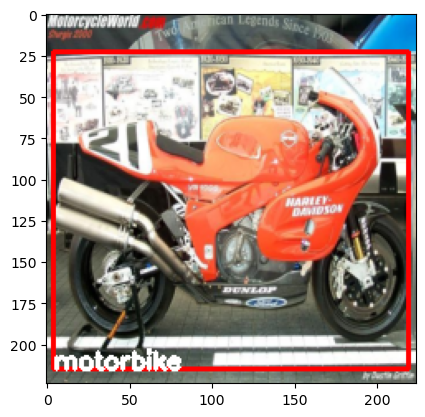

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


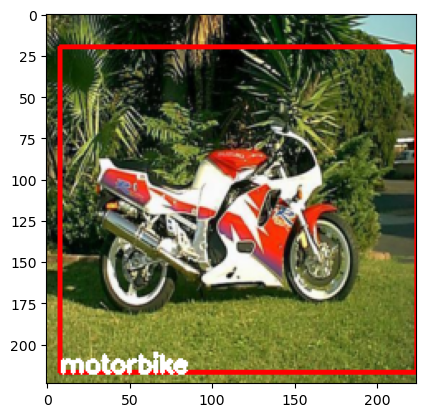

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


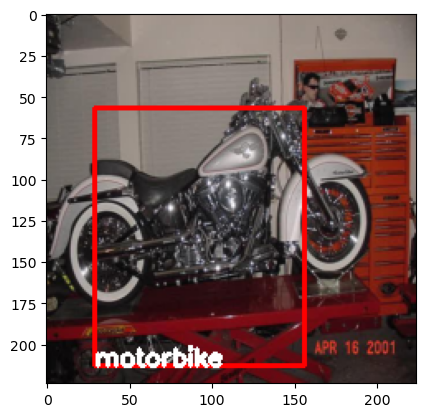

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


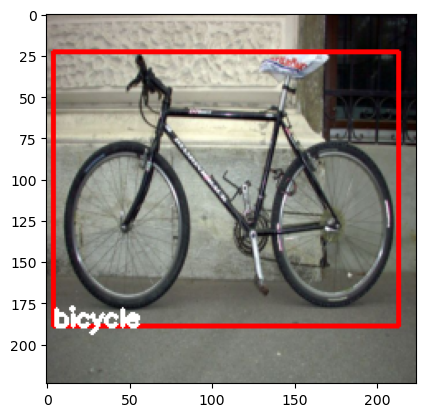

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


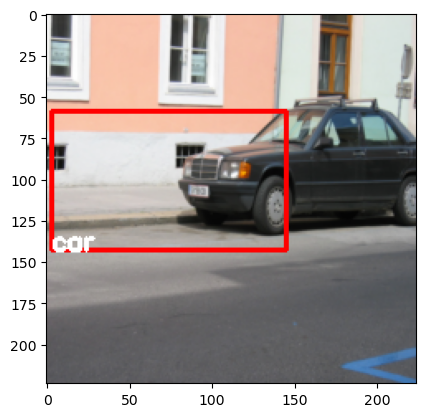

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


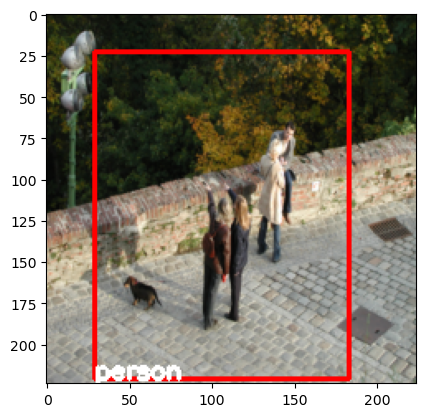

In [15]:
for j in [1, 100, 200, 500, 800, 1000]:
    
    output = model(images[j:j+32])[:1]

    # Threshold for detection
    THRESH = 0.25

    # Get object positions
    object_positions = torch.where(output[..., 0] >= THRESH)
    selected_output = output[object_positions]

    # Initialize lists for final boxes and scores
    final_boxes = []
    final_scores = []

    # Iterate through object positions
    for i in range(len(object_positions[0])):
        if selected_output[i][0] > THRESH:
            # Extract box parameters
            output_box = selected_output[i][1:5].float()
            x_centre = (object_positions[1][i] + output_box[0]) * 32
            y_centre = (object_positions[2][i] + output_box[1]) * 32
            x_width, y_height = torch.abs(224 * output_box[2]), torch.abs(224 * output_box[3])
            
            x_min, y_min = int(x_centre - (x_width / 2)), int(y_centre - (y_height / 2))
            x_max, y_max = int(x_centre + (x_width / 2)), int(y_centre + (y_height / 2))

            # Adjust bounding box coordinates
            x_min = max(0, x_min)
            y_min = max(0, y_min)
            x_max = min(224, x_max)
            y_max = min(224, y_max)

            # Append to final boxes
            final_boxes.append([x_min, y_min, x_max, y_max, 
                               classes[torch.argmax(selected_output[i][5:]).item()]])
            final_scores.append(selected_output[i][0].item())


    img = np.array(images[j].permute(1, 2, 0).to('cpu')).copy()
    
    for i in range(len(final_boxes)):

        # Extract object classes and boxes
        object_classes = final_boxes[i][4]
        nms_output = final_boxes[i][0:4]

        x1, y1 = nms_output[:2]
        x2, y2 = nms_output[2:]

        # Specify the color (in BGR format) and thickness
        color = (255, 0, 0) 
        thickness = 2

        # Draw the rectangle
        cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)
        
        # Add text (object classes)
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.5
        font_color = (255, 255, 255)  
        text_position = (x1, y2)  

        cv2.putText(img, object_classes, text_position, font, font_scale, font_color, thickness)
    plt.imshow(img)
    plt.show()